# Validate ABoVE Shrubs Canopy Height Modeling
1. Make stacks with prediction layers (`do_stack()`)  
2. Send to JC for processing  
3. footprint the stacks; alternatively can footprint the predictions (`footprintlib`)
4. spatially select subset of preds or stacks to examine  
5. view a CHM prediction   
5. find intersection with LVIS footprints  
6. Get intersection polygons for validation (not needed to run validation function - just to pre-examine areas most useful for validation)    
7. validate for intersection of pred and lvis

Paul Montesano  
June 26 20223

In [2]:
import rasterio
from rasterio.mask import mask
from rasterio.plot import show

import fiona
import geopandas as gpd
import pandas as pd
import numpy as np

import contextily as ctx

import os
import sys
import glob
sys.path.append('/home/pmontesa/code/pygeotools')
from pygeotools.lib import *

sys.path.append('/home/pmontesa/code/geoscitools')
import footprintlib
import vhrlib

# This is a private repo
sys.path.append('/home/pmontesa/code/dgtools')
from dgtools.lib import dglib

# 
sys.path.append('/home/pmontesa/code/above-shrubs')
import notebooks.predlib

import random
import shapely
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

/tmp/ipykernel_2114688/1782959623.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [3]:
from multiprocessing import Pool
from functools import partial

In [4]:
outstackdir = '/explore/nobackup/projects/ilab/projects/ABoVE-Shrubs/data/srlite-dtm-stacks'

#### Path to IFSAR DTM mosaic

In [5]:
dtm_path = '/explore/nobackup/projects/dem/AK_IFSAR/alaska_ifsar_dtm_20221222.tif'

In [6]:
TEST = False

### Get SRLite strips, make footprint, get vhr metadata

In [11]:
glob.glob('/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/**' + '/WV02_20100709_M1BS_1030010006AC3100*')

['/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/split_6/WV02_20100709_M1BS_1030010006AC3100-sr-02m.tif']

In [7]:
fn_list_srlite_FULL = glob.glob('/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/**/*-sr-02m.tif')
if TEST: fn_list_srlite_FULL = fn_list_srlite_FULL[0:2]
print(len(fn_list_srlite_FULL))

2075


In [ ]:
%%time
with Pool(processes=35) as pool:
    f_gdf_lst = pool.map(partial(footprintlib.raster_footprint, DO_DATAMASK=False, GET_ONLY_DATASETMASK=False, R_READ_MODE='r', MANY_CRS=True), fn_list_srlite_FULL)

In [9]:
footprint_gdf_srlite = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME='CHM pred stack', DROP_DUPLICATES=True)

NameError: name 'f_gdf_lst' is not defined

In [ ]:
import importlib
importlib.reload(footprintlib)
footprint_gdf_srlite = footprintlib.get_attributes_from_filename(footprint_gdf_srlite, 'SR', '-sr')
footprint_gdf_srlite.head()

### Example: find a particular SRLite strip

In [ ]:
footprint_gdf_srlite[footprint_gdf_srlite['footprint_name'].str.contains('WV02_20100709_M1BS_1030010006AC3100')]

#### Get vhr metadata - used for filtering
only build pred stacks for July and August

In [17]:
# Get xmls (from TOA dir)
f_list_toa_xml =glob.glob('/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/toa/alaska/**/*-toa.xml')
len(f_list_toa_xml)

2176

In [18]:
import importlib
importlib.reload(vhrlib)

<module 'vhrlib' from '/home/pmontesa/code/geoscitools/vhrlib.py'>

In [19]:
%%time

with Pool(processes=35) as pool:
    vhr_df_list = pool.map(partial(vhrlib.make_vhr_xml_dataframe), f_list_toa_xml)
vhr_df = pd.concat(vhr_df_list)

# Prefer to join VHR df to my footprints
footprints_vhr_meta_gdf = pd.merge(footprint_gdf_srlite, vhr_df[['satid','catid', 'el', 'az', 'sunel', 'sunaz']], how='left', left_on = 'catid', right_on = 'catid', copy=False)

CPU times: user 1.86 s, sys: 480 ms, total: 2.34 s
Wall time: 28.8 s


### Filter SRlite for stacking
you need a filtered list of SRlite - our model is built on **July** & **August** SRlite data

array([[<AxesSubplot: title={'center': 'year'}>]], dtype=object)

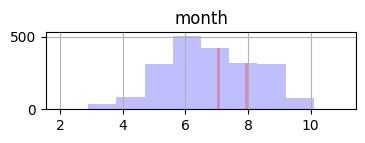

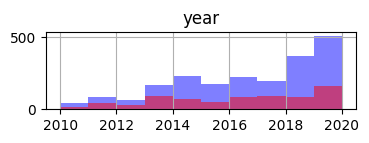

In [20]:
ax_month = footprints_vhr_meta_gdf.hist(column='month',  figsize=(4,1), color='blue', alpha=0.25)
ax_year = footprints_vhr_meta_gdf.hist(column='year',  figsize=(4,1), color='blue', alpha=0.5)
footprints_vhr_meta_gdf_FILT = footprints_vhr_meta_gdf[ (footprints_vhr_meta_gdf.month == 7) | (footprints_vhr_meta_gdf.month == 8) ]
footprints_vhr_meta_gdf_FILT.hist(column='month',  figsize=(4,1), color='red', alpha = 0.25, ax=ax_month)
footprints_vhr_meta_gdf_FILT.hist(column='year',  figsize=(4,1), color='red', alpha = 0.5, ax=ax_year)

In [21]:
# Get the full path of all the FILTERED SRlite data
fn_list_srlite_FILT = (footprints_vhr_meta_gdf_FILT.path + '/' + footprints_vhr_meta_gdf_FILT.file).to_list()
len(fn_list_srlite_FILT)

740

In [22]:
fn_list_srlite_FILT_SUB = random.sample(fn_list_srlite_FILT, 20)
fn_list_srlite_FILT_SUB[0:2]

['/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/split_6/WV02_20150714_M1BS_10300100446B9F00-sr-02m.tif',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite_1.0.1/srlite/alaska/split_6/WV03_20180705_M1BS_104001003E519500-sr-02m.tif']

### Save list of input for prediction stacking

In [30]:
# Save this list to CSV for applying the predictions
import csv
PRED_FILE_LIST_FN = '/explore/nobackup/projects/ilab/projects/ABoVE-Shrubs/data/list_predstack_file_id_for_val_v01.csv'
pred_file_df = pd.read_csv(PRED_FILE_LIST_FN)

PRED_FILE_SRLITE_FN_LIST = [p for p in fn_list_srlite_FILT for fid in pred_file_df.file_id.to_list() if fid in p]
len(PRED_FILE_SRLITE_FN_LIST)

# write list of full paths of srlite we identified in validate_chm.ipynb that is good for validation
PRED_FILE_SRLITE_FN_LIST_FN = '/explore/nobackup/projects/ilab/projects/ABoVE-Shrubs/data/list_srlite_path_for_predstack.csv'
df = pd.DataFrame(PRED_FILE_SRLITE_FN_LIST, columns=["srlite_path"])
df.to_csv(PRED_FILE_SRLITE_FN_LIST_FN, index=False)

In [25]:
[s for s in list if sub in s]

,file_id
0,WV02_20100709_M1BS_1030010006AC3100
1,WV02_20100731_M1BS_103001000613CA00
2,WV02_20100820_M1BS_1030010006A83500
3,WV02_20100824_M1BS_10300100066AFE00
4,WV02_20110704_M1BS_103001000C11B700
...,...
78,WV02_20140706_M1BS_1030010033C86E00
79,WV02_20140706_M1BS_1030010034437200
80,WV02_20140707_M1BS_103001003288A000
81,WV02_20140707_M1BS_103001003368B700


### Make prediction stacks

In [25]:
import importlib
importlib.reload(notebooks.predlib)

<module 'notebooks.predlib' from '/home/pmontesa/code/above-shrubs/notebooks/predlib.py'>

In [445]:
# # Find and geth path for a small test case
# test_input_fn = [f for f in fn_list_srlite if 'WV03_20180921_M1BS_104001004242D900-sr-02m' in f]
# test_input_fn
# z = above_shrubs.lib.predlib.do_stack(test_input_fn[0], dtm_path='/explore/nobackup/projects/dem/AK_IFSAR/alaska_ifsar_dtm_20221222.tif', outdir='/home/pmontesa/code/above-shrubs')

# TODO: in progress...
need to include the cloudmask and then apply common mask to create a finished stack  
/adapt/nobackup/projects/ilab/data/srlite/cloudmask/Alaska/WV02_20180527_M1BS_103001007E5F8400-toa.cloudmask.v1.2.tif

In [ ]:
%%time
with Pool(processes=38) as pool:
    fn_pred_stack_list = pool.map(partial(notebooks.predlib.do_pred_stack, dtm_path='/explore/nobackup/projects/dem/AK_IFSAR/alaska_ifsar_dtm_20221222.tif', outdir=outstackdir), fn_list_srlite_FILT)

### Footprint stacks

In [123]:
fn_pred_stack_list = glob.glob( outstackdir + '/**/*-sr-02m_pred_stack.tif')

In [124]:
# Check FILT list against pred stack list - any pred stacks missing?

In [125]:
%%time
with Pool(processes=35) as pool:
    f_gdf_lst = pool.map(partial(footprintlib.raster_footprint, DO_DATAMASK=False, GET_ONLY_DATASETMASK=False, R_READ_MODE='r', MANY_CRS=True), fn_pred_stack_list)

'/explore/nobackup/projects/ilab/projects/ABoVE-Shrubs/data/srlite-dtm-stacks/WV02_20180721_M1BS_10300100826C6C00-sr-02m/WV02_20180721_M1BS_10300100826C6C00-sr-02m_pred_stack.tif' not recognized as a supported file format.
/explore/nobackup/projects/ilab/projects/ABoVE-Shrubs/data/srlite-dtm-stacks/WV02_20180721_M1BS_10300100826C6C00-sr-02m/WV02_20180721_M1BS_10300100826C6C00-sr-02m_pred_stack.tif
'/explore/nobackup/projects/ilab/projects/ABoVE-Shrubs/data/srlite-dtm-stacks/WV02_20110812_M1BS_103001000C8BBA00-sr-02m/WV02_20110812_M1BS_103001000C8BBA00-sr-02m_pred_stack.tif' not recognized as a supported file format.
/explore/nobackup/projects/ilab/projects/ABoVE-Shrubs/data/srlite-dtm-stacks/WV02_20110812_M1BS_103001000C8BBA00-sr-02m/WV02_20110812_M1BS_103001000C8BBA00-sr-02m_pred_stack.tif
'/explore/nobackup/projects/ilab/projects/ABoVE-Shrubs/data/srlite-dtm-stacks/WV02_20140809_M1BS_1030010035764600-sr-02m/WV02_20140809_M1BS_1030010035764600-sr-02m_pred_stack.tif' not recognized as 

In [126]:
footprint_pred_stacks = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME='CHM pred stack', DROP_DUPLICATES=True)

Building GDF from list...


In [127]:
footprint_pred_stacks = footprintlib.get_attributes_from_filename(footprint_pred_stacks, 'Pred. Stack', '-sr')
footprint_pred_stacks.head()

# Pred. Stack stacks: 410


,file,geometry,footprint_name,path,area_km2,area_ha,type,catid,sensor,year,month
0,WV02_20130728_M1BS_1030010024919100-sr-02m_pre...,"POLYGON ((-134.44527 57.96734, -134.42837 59.0...",WV02_20130728_M1BS_1030010024919100,/explore/nobackup/projects/ilab/projects/ABoVE...,2346.302396,234630.2396,Pred. Stack,1030010024919100,WV02,2013,7
1,WV03_20190806_M1BS_104001004E03D100-sr-02m_pre...,"POLYGON ((-129.86394 56.02306, -129.87725 56.6...",WV03_20190806_M1BS_104001004E03D100,/explore/nobackup/projects/ilab/projects/ABoVE...,1061.651864,106165.1864,Pred. Stack,104001004E03D100,WV03,2019,8
2,WV02_20200703_M1BS_10300100A7144200-sr-02m_pre...,"POLYGON ((-135.68390 56.91010, -135.70504 58.0...",WV02_20200703_M1BS_10300100A7144200,/explore/nobackup/projects/ilab/projects/ABoVE...,2545.452960,254545.2960,Pred. Stack,10300100A7144200,WV02,2020,7
3,WV02_20100803_M1BS_103001000683C500-sr-02m_pre...,"POLYGON ((-136.14901 58.22481, -136.16393 58.6...",WV02_20100803_M1BS_103001000683C500,/explore/nobackup/projects/ilab/projects/ABoVE...,983.757180,98375.7180,Pred. Stack,103001000683C500,WV02,2010,8
4,WV02_20160827_M1BS_103001005CBE7C00-sr-02m_pre...,"POLYGON ((-135.17788 57.52543, -135.18046 58.0...",WV02_20160827_M1BS_103001005CBE7C00,/explore/nobackup/projects/ilab/projects/ABoVE...,1192.209408,119220.9408,Pred. Stack,103001005CBE7C00,WV02,2016,8


In [ ]:
# Did we do predictions for all the filtered srlite we want?
#footprints_vhr_meta_gdf_FILT

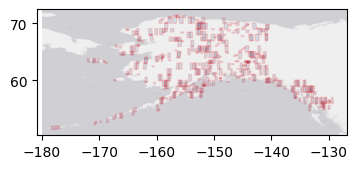

In [128]:
ax_main = footprint_pred_stacks.plot(figsize=(4,4), alpha=0.15, ec='red')
ax_main = ctx.add_basemap(ax_main, crs=4326, source = ctx.providers.Esri.WorldGrayCanvas, attribution=' ' ) #Esri.NatGeoWorldMap. Esri.WorldGrayCanvas Esri.WorldImagery

In [129]:
footprint_pred_stacks.to_file(os.path.join(outstackdir, 'footprints_pred_stacks.gpkg'))

### Read predition stack footprint back in

In [130]:
len(fn_pred_stack_list)

425

In [47]:
footprint_gdf_stacks = gpd.read_file(os.path.join(outstackdir, 'footprints_pred_stacks.gpkg'))